In [1]:
import os
import urllib
import zipfile
import numpy as np
import torch
from torch_geometric.utils import dense_to_sparse
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from torch_geometric_temporal.dataset import PemsBayDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.nn.recurrent import A3TGCN, A3TGCN2
from torch_geometric_temporal.nn.recurrent import TGCN, TGCN2
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam
from models import TrafficA3TGCNSingleShot, TrafficA3TGCN_LSTM
from traffic_datasets import PemsBayDatasetLoaderSingleValue

In [2]:
dataloader = PemsBayDatasetLoaderSingleValue()

In [3]:
# load dataset
dataloader = PemsBayDatasetLoaderSingleValue()
num_in_minutes = 60
num_out_minutes = 30
num_in = num_in_minutes//5
num_out = num_out_minutes//5
dataset_normalized, dataset_regular, means, stds  = dataloader.get_dataset(num_in, num_out)

print(f"Number of {5} minute predictor intervals: {num_in}")
print(f"Number of {5} minute estimated intervals: {num_out}")

Number of 5 minute predictor intervals: 12
Number of 5 minute estimated intervals: 6


In [4]:
# split the dataset
_, test_dataset_normalized = temporal_signal_split(dataset_normalized, train_ratio=0.8)
_, test_dataset_regular= temporal_signal_split(dataset_regular , train_ratio=0.8)

In [6]:
# load model from saved path
device = torch.device('cuda') # cuda

batch_size = 64
model_single_shot = TrafficA3TGCNSingleShot(
    node_features=2, 
    periods_in=num_in, 
    periods_out = num_out, 
    dropout_rate = 0.1, 
    batch_size=batch_size
).to(device)

model_lstm = TrafficA3TGCN_LSTM(
    node_features=2, 
    node_out_features=1,
    periods_in=num_in, 
    periods_out = num_out, 
    dropout_rate = 0.1, 
    batch_size=batch_size
).to(device)

PATH = "temporal_gnn_traffic_lstm.pth"
model_lstm.load_state_dict(torch.load(PATH))
PATH = "temporal_gnn_traffic.pth"
model_single_shot.load_state_dict(torch.load(PATH))
# use the testing set to find a period of time to predict traffic
# plot actual traffic value and the predicted values on the same plot
means = torch.tensor(means.reshape((2,1))).to(device)
stds = torch.tensor(stds.reshape((2,1))).to(device)


In [7]:
means

tensor([[61.7738],
        [ 0.4985]], device='cuda:0')

In [8]:
model_lstm

TrafficA3TGCN_LSTM(
  (tgnn): A3TGCN2(
    (_base_tgcn): TGCN2(
      (conv_z): GCNConv(2, 16)
      (linear_z): Linear(in_features=32, out_features=16, bias=True)
      (conv_r): GCNConv(2, 16)
      (linear_r): Linear(in_features=32, out_features=16, bias=True)
      (conv_h): GCNConv(2, 16)
      (linear_h): Linear(in_features=32, out_features=16, bias=True)
    )
  )
  (lstm): LSTM(16, 16, num_layers=2)
  (linear): Linear(in_features=16, out_features=1, bias=True)
)

In [9]:
model_single_shot

TrafficA3TGCNSingleShot(
  (tgnn): A3TGCN2(
    (_base_tgcn): TGCN2(
      (conv_z): GCNConv(2, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(2, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(2, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear1): Linear(in_features=32, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=6, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [10]:
# get testing time interval
iterable_test_normalized = list(test_dataset_normalized)
iterable_test_regular = list(test_dataset_regular)
num_of_timesteps = len(iterable_test_regular)
sensor_number = 1 # which sensor to plot data over time (there are 325)
iterable_test_regular[0]

Data(x=[325, 2, 12], edge_index=[2, 2694], edge_attr=[2694], y=[325, 6])

In [11]:
data_to_plot_normalized = [(instance.x[sensor_number,0,0],instance.x[sensor_number,1,0]) for instance in iterable_test_normalized[0:num_of_timesteps]]
data_to_plot_regular = [(instance.x[sensor_number,0,0],instance.x[sensor_number,1,0]*288) for instance in iterable_test_regular[0:num_of_timesteps]]

In [12]:
data_to_plot_regular[0:5]
# the 225, 224 numbers are the 5 minute time intervals. 225 is the 225th 5 minute time interval that day
# 225*5 is 1125 minutes past midnight: 6:45pm

[(tensor(19.6000), tensor(221.)),
 (tensor(19.7000), tensor(222.)),
 (tensor(20.1000), tensor(223.)),
 (tensor(22.3000), tensor(224.)),
 (tensor(22.5000), tensor(225.))]

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [14]:
data_plot = pd.DataFrame(
    {
        "Traffic Sensor Speed(mph)":[float(x[0]) for x in data_to_plot_regular], 
        "Time of Day":[float(x[1]) for x in data_to_plot_regular]
    }
)

In [15]:
data_plot

,Traffic Sensor Speed(mph),Time of Day
0,19.600000,221.0
1,19.700001,222.0
2,20.100000,223.0
3,22.299999,224.0
4,22.500000,225.0
...,...,...
10413,65.400002,266.0
10414,66.199997,267.0
10415,65.900002,268.0
10416,65.900002,269.0


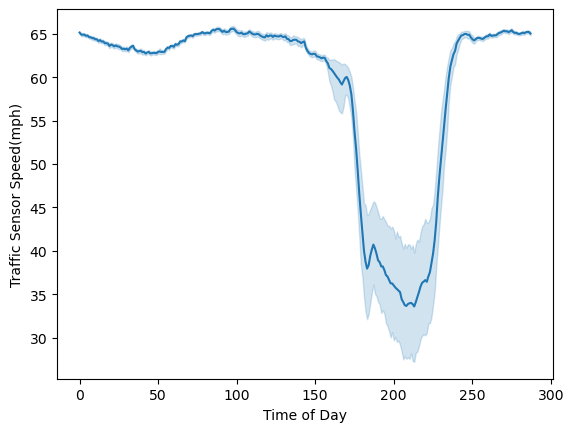

In [16]:
sns.lineplot(x = "Time of Day", y = "Traffic Sensor Speed(mph)", data=data_plot)
plt.show()

In [21]:
scaler = torch.tensor([[1],[288]]).to(device)
def add_to_dataframe(X_batch, y_hat, batch_size, num_in, num_out, label):
    res = {
        "Sensor":[],
        "Model":[],
        "Traffic Sensor Speed(mph)":[], 
        "Time of Day":[]
    }
    for i in range(X_batch.shape[0]):
        X, y = X_batch[i]*stds+means, y_hat[i]*stds[0]+means[0]
        X = X*scaler
        for sensor in range(325):
            X_sensor, y_sensor = X[sensor], y[sensor].tolist()
            X_timesteps = X_sensor[1,:].tolist() # get the timesteps for all 12 input steps
         
            X_speeds = X_sensor[0,:].tolist()
         
            y_timesteps = [X_timesteps[-1]+i for i in range(num_out)]

            res["Sensor"].extend([sensor]*(num_in+num_out))
            res["Model"].extend(["input"]*num_in + [label]*num_out)
            res["Traffic Sensor Speed(mph)"].extend(X_speeds + y_sensor)
            res["Time of Day"].extend(X_timesteps + y_timesteps)
    return pd.DataFrame(res)
            
            

In [22]:
# time to calculate the prediction
model_lstm.eval()
model_single_shot.eval()
val_dataset = test_dataset_normalized
print(len(val_dataset.features))
res_data = []
with torch.no_grad():
    for i in range(0, len(val_dataset.features), batch_size):
        batch_instances_normalized = iterable_test_normalized[i:i+batch_size]
        X_batch_normaized = torch.stack([instance.x for instance in batch_instances_normalized]).to(device)
        edge_index_batch = batch_instances_normalized[0].edge_index.to(device)
        edge_features_batch = batch_instances_normalized[0].edge_attr.to(device)
        
        y_hat_lstm = model_lstm(X_batch_normaized, edge_index_batch, edge_features_batch)
        y_hat_lstm = y_hat_lstm.squeeze(2) # for lstm model only
        res_data.append(add_to_dataframe(X_batch_normaized, y_hat_lstm, batch_size, num_in, num_out, "LSTM Decoder"))
        
        y_hat_ss = model_single_shot(X_batch_normaized, edge_index_batch, edge_features_batch)
        res_data.append(add_to_dataframe(X_batch_normaized, y_hat_ss, batch_size, num_in, num_out, "Single Shot Decoder"))
        

10418


In [23]:
res_data[0]

,Sensor,Model,Traffic Sensor Speed(mph),Time of Day
0,0,input,72.400002,221.000000
1,0,input,71.599998,222.000000
2,0,input,71.300003,223.000000
3,0,input,73.099998,224.000000
4,0,input,73.099998,225.000000
...,...,...,...,...
374395,324,LSTM Decoder,67.843941,7.999999
374396,324,LSTM Decoder,67.830559,8.999999
374397,324,LSTM Decoder,67.840736,9.999999
374398,324,LSTM Decoder,67.838570,10.999999


In [24]:
final_data = pd.concat(res_data)
final_data["Time of Day"] = final_data["Time of Day"].round(0).astype(np.int32)

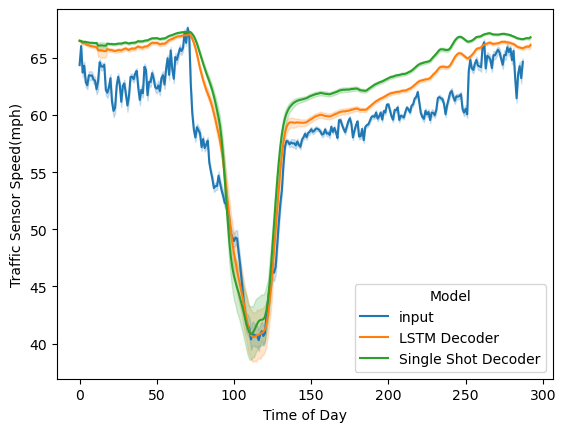

In [34]:
sns.lineplot(x = "Time of Day", y = "Traffic Sensor Speed(mph)", data=final_data[final_data.Sensor==292], hue="Model")
plt.show()

In [173]:
means

array([61.77375  ,  0.4984733], dtype=float32)

In [174]:
stds

array([9.293026  , 0.28541598], dtype=float32)